In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
%matplotlib inline
import cv2
import glob
from IPython.display import Image
import scipy as sp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization, concatenate, GlobalAveragePooling2D
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil
from tensorflow.keras.regularizers import l2
from PIL import Image
from tensorflow.keras.optimizers import Adam

In [3]:
# get text data
image_path ="/content/drive/MyDrive/CSC180/Final Project/archive/filtered_images/"
data = pd.read_csv("/content/drive/MyDrive/CSC180/Final Project/archive/metadata/Train.csv")

In [4]:
data.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0


In [5]:
# Count the number of rows for each class
class_counts = data['class'].value_counts()

# Display the counts for each class
print(class_counts)

class
Trophozoite    15838
WBC             7004
NEG              688
Name: count, dtype: int64


In [6]:
binary_data = data[data['class'].isin(['WBC', 'NEG'])]

In [7]:
# Group by Image_ID and just keep image ID and label
aggregated_data = binary_data.groupby('Image_ID').agg({
    'class': lambda x: x.mode()[0]
}).reset_index()


In [8]:
aggregated_data.head(15)

,Image_ID,class
0,id_0051lznyrt.jpg,WBC
1,id_00m1onu6hj.jpg,NEG
2,id_00n92f65ke.jpg,NEG
3,id_00sirs797x.jpg,WBC
4,id_013o32svbt.jpg,NEG
5,id_021o79u9zs.jpg,WBC
6,id_02q5ah1zvq.jpg,WBC
7,id_042y6d5xok.jpg,WBC
8,id_04gtt1v9w0.jpg,WBC
9,id_087dra2apu.jpg,WBC


In [9]:
# Check the unique values in the 'class' column
unique_classes = aggregated_data['class'].value_counts()

# Print the unique classes
print(unique_classes)

class
WBC    1583
NEG     688
Name: count, dtype: int64


In [10]:
# Filter aggregated_data for the classes you want to include
filtered_data = aggregated_data[aggregated_data['class'].isin(['WBC', 'NEG'])]

# Map class labels to binary values (WBC = 1, NEG = 0)
filtered_data['class'] = filtered_data['class'].map({'WBC': 1, 'NEG': 0})
print(f"Downsampled class distribution: \n{filtered_data['class'].value_counts()}")

Downsampled class distribution: 
class
1    1583
0     688
Name: count, dtype: int64


In [11]:
def load_and_preprocess_image(image_id):
    image_file = os.path.join(image_path, image_id)
    img = load_img(image_file, target_size=(128, 128))  # Resize image as needed
    img = img_to_array(img) / 255.0  # Normalize image (values between 0 and 1)
    return img  # Return only the RGB image

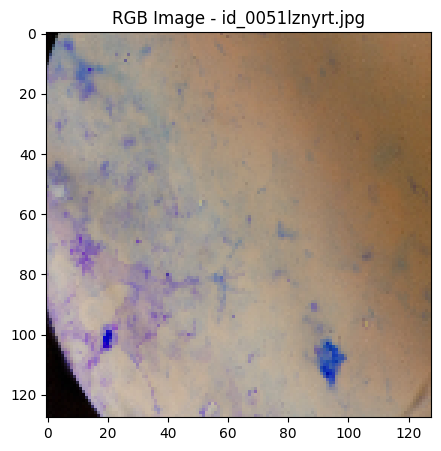

Processing image 1 of 2271


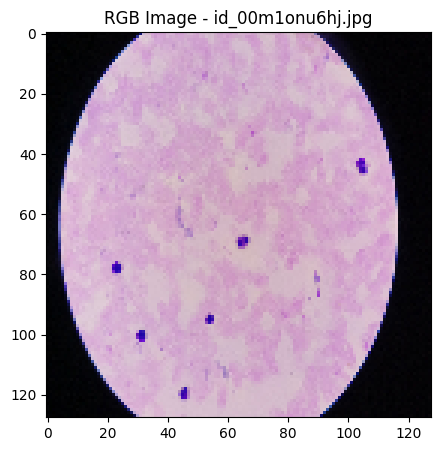

Processing image 2 of 2271
Processing image 3 of 2271
Processing image 4 of 2271
Processing image 5 of 2271
Processing image 6 of 2271
Processing image 7 of 2271
Processing image 8 of 2271
Processing image 9 of 2271
Processing image 10 of 2271
Processing image 11 of 2271
Processing image 12 of 2271
Processing image 13 of 2271
Processing image 14 of 2271
Processing image 15 of 2271
Processing image 16 of 2271
Processing image 17 of 2271
Processing image 18 of 2271
Processing image 19 of 2271
Processing image 20 of 2271
Processing image 21 of 2271
Processing image 22 of 2271
Processing image 23 of 2271
Processing image 24 of 2271
Processing image 25 of 2271
Processing image 26 of 2271
Processing image 27 of 2271
Processing image 28 of 2271
Processing image 29 of 2271
Processing image 30 of 2271
Processing image 31 of 2271
Processing image 32 of 2271
Processing image 33 of 2271
Processing image 34 of 2271
Processing image 35 of 2271
Processing image 36 of 2271
Processing image 37 of 2271


In [12]:
images = []

for idx, image_id in enumerate(filtered_data['Image_ID']):
    img = load_and_preprocess_image(image_id)  # Load only RGB image
    images.append(img)

    # Plot RGB images
    if idx < 2:  # Plot only the first 2 images for visualization
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"RGB Image - {image_id}")
        plt.show()

    print(f"Processing image {idx + 1} of {len(filtered_data['Image_ID'])}")

In [13]:
# Prepare data for training
X = np.array(images)
y = filtered_data['class'].values

In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Count occurrences in y_train_Global
train_class_counts = pd.Series(y_train).value_counts()
print("Class counts in y_train_Global:")
print(f"Class 0 (NEG): {train_class_counts[0]}")
print(f"Class 1 (WBC): {train_class_counts[1]}")

# Count occurrences in y_test_Global
test_class_counts = pd.Series(y_test).value_counts()
print("\nClass counts in y_test_Global:")
print(f"Class 0 (NEG): {test_class_counts[0]}")
print(f"Class 1 (WBC): {test_class_counts[1]}")

Class counts in y_train_Global:
Class 0 (NEG): 553
Class 1 (WBC): 1263

Class counts in y_test_Global:
Class 0 (NEG): 135
Class 1 (WBC): 320


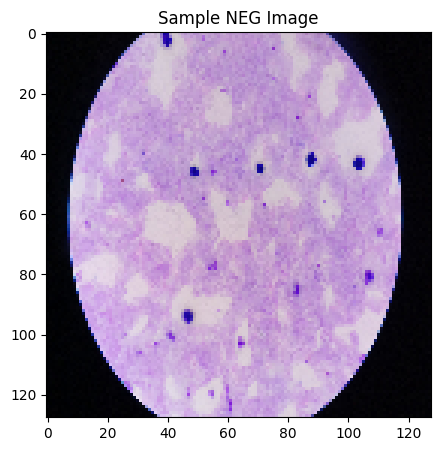

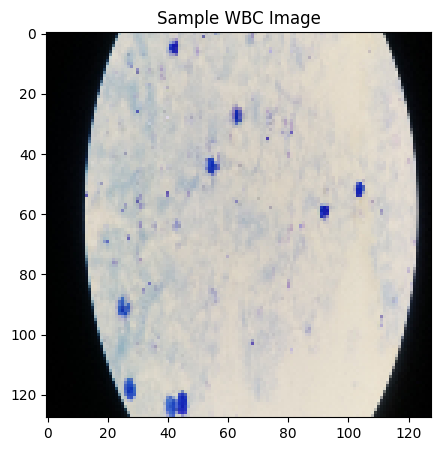

In [21]:
# Filter rows: We filter downsampled_data to get the first NEG and WBC class image IDs.
# Get the index of the image: We match the Image_ID in downsampled_data to the index in images_array.
# Filter the rows for 'NEG' and 'WBC' classes
# Display a sample of NEG and WBC images
neg_sample_index = filtered_data[filtered_data['class'] == 0].index[444]
wbc_sample_index = filtered_data[filtered_data['class'] == 1].index[333]

# Display the first NEG image
plt.figure(figsize=(5, 5))
plt.imshow(X[neg_sample_index])
plt.title("Sample NEG Image")
plt.show()

# Display the first WBC image
plt.figure(figsize=(5, 5))
plt.imshow(X[wbc_sample_index])
plt.title("Sample WBC Image")
plt.show()
y = filtered_data['class'].values

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │         100,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,697 (616.00 KB)

 Trainable params: 157,697 (616.00 KB)

 Non-trainable params: 0 (0.00 B)

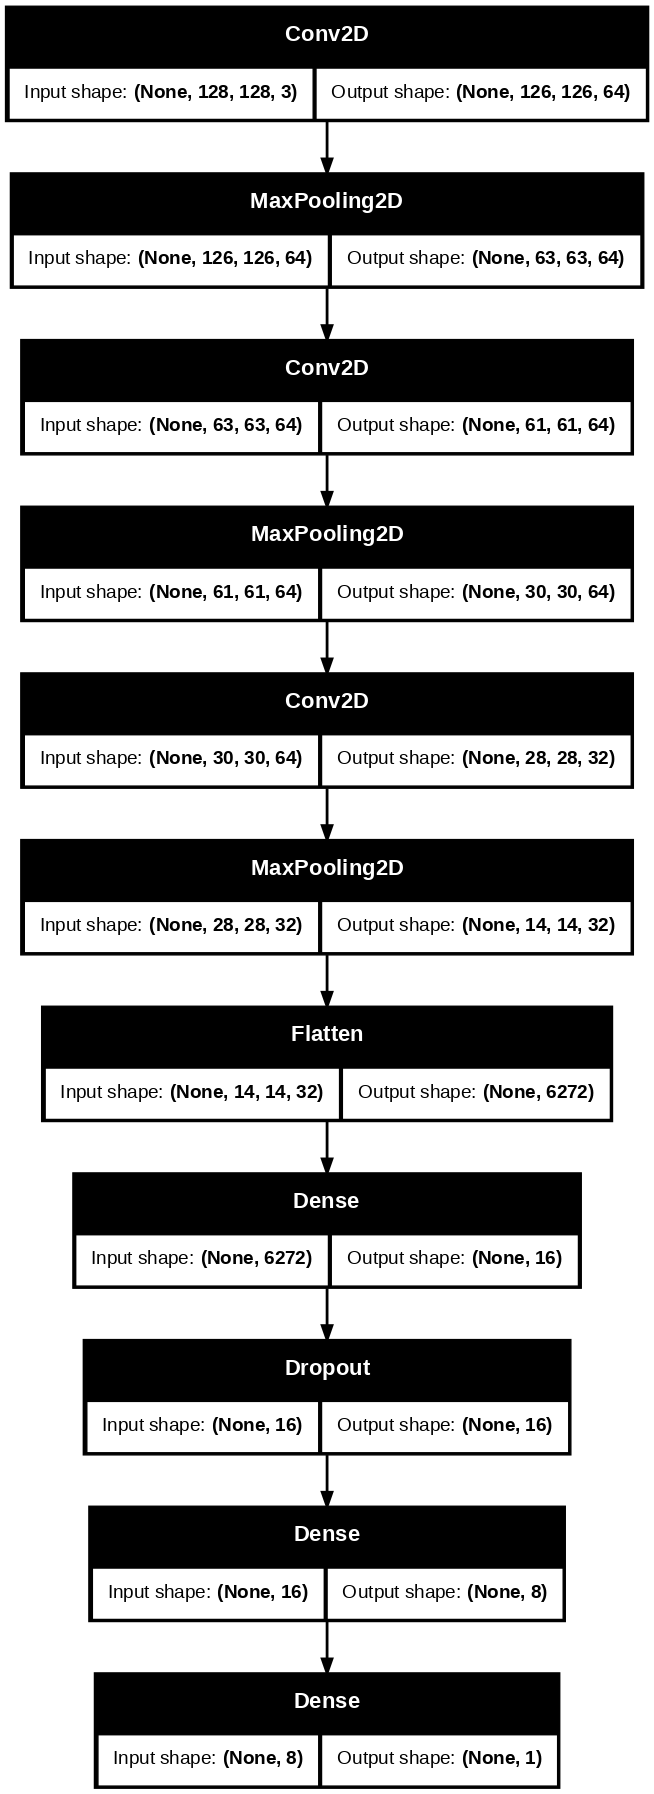

In [ ]:
# Define CNN model
cnn_model = Sequential()

# Add convolutional layers
cnn_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)))  # Input is 128x128 image
cnn_model.add(MaxPooling2D((2, 2)))


cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))  # 2nd Conv layer
cnn_model.add(MaxPooling2D((2, 2)))


cnn_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))  # 3rd Conv layer
cnn_model.add(MaxPooling2D((2, 2)))



# Flatten feature maps for Dense layers
cnn_model.add(Flatten())

# Fully connected dense layers
cnn_model.add(Dense(16, activation='relu'))  # 1st dense layer with 128 neurons
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(8, activation='relu'))  # 2nd dense layer with 64 neurons

# Output layer
cnn_model.add(Dense(1, activation='sigmoid'))  # Output layer for multi-class classification (3 classes)

# Compiling
cnn_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


cnn_model.summary()
plot_model(cnn_model, show_shapes=True, dpi=100)

In [ ]:

checkpoint_filepath = '/content/drive/MyDrive/CSC180/Final Project/Best_WBC_V_NEG_Model.keras'


num_runs = 5

for i in range(num_runs):
    print(f"\nTraining Model Run {i + 1}\n")

    # Define your CNN model
    cnn_model = Sequential()

    # Add convolutional layers
    cnn_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    cnn_model.add(MaxPooling2D((2, 2)))

    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))

    cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))

    # Flatten feature maps for Dense layers
    cnn_model.add(Flatten())

    # Fully connected dense layers
    cnn_model.add(Dense(16, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(8, activation='relu'))

    # Output layer
    cnn_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    cnn_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

    # Define ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath.format(i=i),  # Save a unique file for each run
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Train the CNN model
    cnn_history = cnn_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate the saved best model
    cnn_model.load_weights(checkpoint_filepath.format(i=i))
    evaluation = cnn_model.evaluate(X_test, y_test)
    print(f"Run {i + 1} Test Accuracy: {evaluation[1] * 100:.2f}%")

    # Optionally, log results or store the model accuracy
    print(f"Run {i + 1} completed.\n")


Training Model Run 1



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5516 - loss: 0.7963
Epoch 1: val_loss improved from inf to 0.76979, saving model to /content/drive/MyDrive/CSC180/Final Project/Best_WBC_V_NEG_Model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5522 - loss: 0.7961 - val_accuracy: 0.7033 - val_loss: 0.7698
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6337 - loss: 0.7684
Epoch 2: val_loss improved from 0.76979 to 0.73424, saving model to /content/drive/MyDrive/CSC180/Final Project/Best_WBC_V_NEG_Model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6333 - loss: 0.7683 - val_accuracy: 0.7033 - val_loss: 0.7342
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6288 - loss: 0.7454
Epoch 3: val_loss improved from 0.73424 to 0.70273, saving model to /content/drive/MyDrive/CSC180/Final Project/Best_WBC_V_NEG_Model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6287 - loss: 0.7453 - val_accuracy: 0.7033 - v

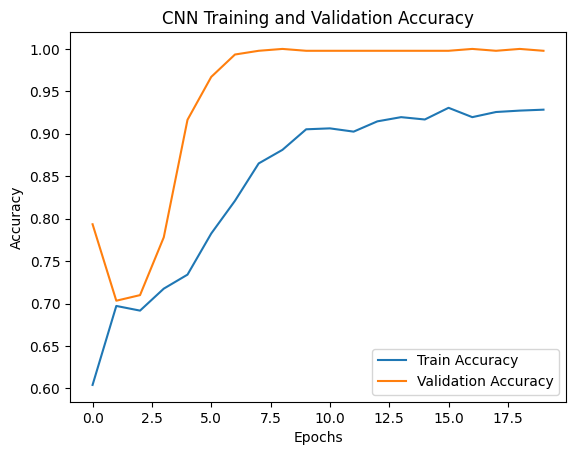

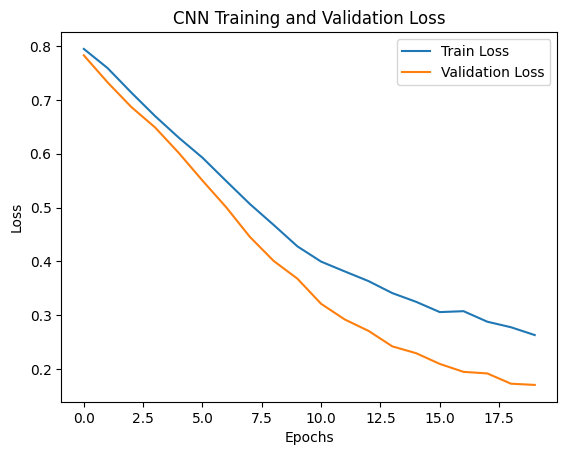

In [ ]:
cnn_model.load_weights(checkpoint_filepath)

# Plot training and validation accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')  # CNN training accuracy
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')  # CNN validation accuracy
plt.legend()
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(cnn_history.history['loss'], label='Train Loss')  # CNN training loss
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')  # CNN validation loss
plt.legend()
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
# Plot ROC curve for the model's predictions
def plot_roc_curve(pred, y_true):
    fpr, tpr, _ = roc_curve(y_true, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 99.78%
Test F1 Score: 1.00


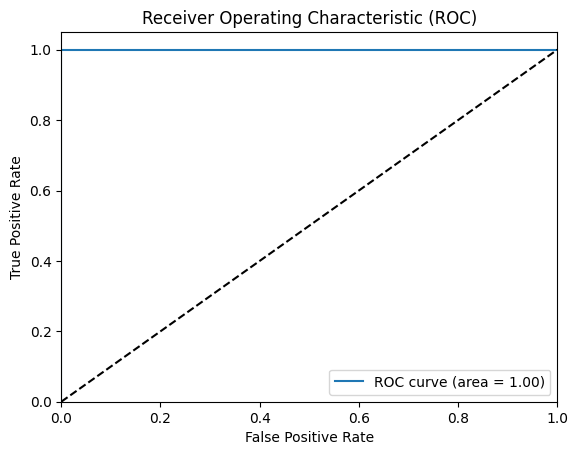

In [ ]:
# Make predictions on the test set
y_pred_probs = cnn_model.predict(X_test)  # Get probabilities from the model
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Calculate model accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1 Score: {f1:.2f}")

# Plot the ROC curve
plot_roc_curve(y_pred_probs, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


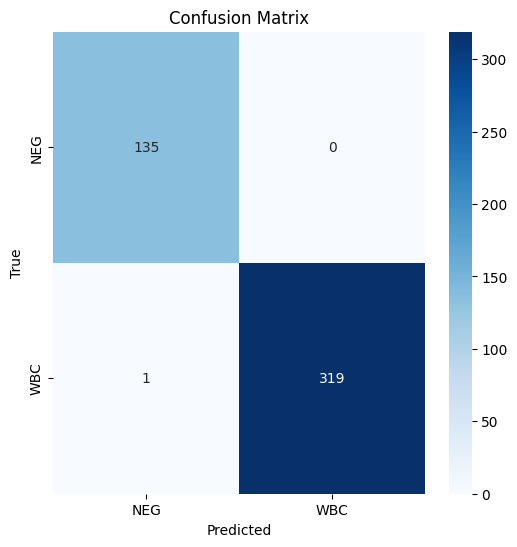

              precision    recall  f1-score   support

         NEG       0.99      1.00      1.00       135
         WBC       1.00      1.00      1.00       320

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455



In [ ]:
# Make predictions
y_pred = cnn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with class labels
labels = ['NEG', 'WBC']  # Your binary class labels
plt.figure(figsize=(6, 6))  # Adjust figure size for better clarity
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=labels))
